In [15]:
import xarray as xr
import dask
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import glob
import pandas as pd
import os

def spatial_mean(da):
    """Computes the spatial mean if lat and lon dimensions are present."""
    if 'lat' in da.dims and 'lon' in da.dims:
        return da.mean(dim=['lat', 'lon'])
    return da

# Convert cftime.DatetimeNoLeap to numpy.datetime64
def convert_time(ds):
    ds['time'] = [pd.Timestamp(time.strftime()) for time in ds['time'].values]
    return ds


# Data Retrieval
    ## Select either Monethly (h0) daily (h1) or Hourly(h2) using wild card

In [16]:
# Directory where the netCDF files are located
data_directory = '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/sim_results/monthly'  # Current directory. Adjust this if your files are elsewhere.

# File pattern
# h2 is two years of daily files, each file contains 24 hourly output  
file_pattern = "i.e215.I2000Clm50SpGs.hw_production.02.clm2.h0*.nc"

file_path_pattern = os.path.join(data_directory, file_pattern)

## Get the list of files using the pattern

In [17]:
file_list = glob.glob(file_path_pattern)
file_list.sort(key=lambda x: os.path.basename(x).split('.')[-2])


In [18]:
# os.listdir(directory)
file_list

['/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/sim_results/monthly/i.e215.I2000Clm50SpGs.hw_production.02.clm2.h0.1985-01.nc',
 '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/sim_results/monthly/i.e215.I2000Clm50SpGs.hw_production.02.clm2.h0.1985-02.nc',
 '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/sim_results/monthly/i.e215.I2000Clm50SpGs.hw_production.02.clm2.h0.1985-03.nc',
 '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/sim_results/monthly/i.e215.I2000Clm50SpGs.hw_production.02.clm2.h0.1985-04.nc',
 '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/sim_results/monthly/i.e215.I2000Clm50SpGs.hw_production.02.clm2.h0.1985-05.nc',
 '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/sim_results/monthly/i.e215.I2000Clm50SpGs.hw_production.02.clm2.h0.1985-06.nc',
 '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/sim_results/monthly/i.e215.I2000Clm50SpGs.hw_production.02.clm2.h0.1985-07.nc',
 '/Trex/case_results

## Open the files using Dask and Xarray

In [19]:
ds = xr.open_mfdataset(file_list, combine='by_coords', engine='netcdf4')
# ds = xr.open_mfdataset(file_list, combine='by_coords', engine='netcdf4')

## Convert the cftime.DatetimeNoLeap objects to pandas Timestamps

In [20]:
ds = convert_time(ds)

## examine the xarray object

In [21]:
ds

<xarray.Dataset>
Dimensions:        (levgrnd: 25, levlak: 10, levdcmp: 1, time: 360, lon: 288,
                    lat: 192, hist_interval: 2)
Coordinates:
  * levgrnd        (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levlak         (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp        (levdcmp) float32 1.0
  * time           (time) datetime64[ns] 1985-02-01 1985-03-01 ... 2015-01-01
  * lon            (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat            (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
Dimensions without coordinates: hist_interval
Data variables: (12/76)
    mcdate         (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    mcsec          (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    mdcur          (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    mscur          (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    nstep          (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    time_bounds    (time, hist_interval) object dask.array<chunksize=(2, 2), meta=np.ndarray>
    ...             ...
    VAPOR_PRES_U   (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WASTEHEAT      (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WBA            (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WBA_R          (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WBA_U          (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WIND           (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
Attributes: (12/38)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 02/13/24 20:20:28
    source:                                    Community Land Model CLM4.0
    hostname:                                  JohnnyThinkStation
    ...                                        ...
    ctype_urban_shadewall:                     73
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1

## Monthly average

In [22]:

monthly_avg = ds.resample(time='1M').mean()

In [40]:
monthly_avg

<xarray.Dataset>
Dimensions:        (time: 360, lat: 192, lon: 288, levgrnd: 25, levlak: 10,
                    levdcmp: 1)
Coordinates:
  * levgrnd        (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levlak         (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp        (levdcmp) float32 1.0
  * lon            (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat            (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * time           (time) datetime64[ns] 1985-02-28 1985-03-31 ... 2015-01-31
Data variables: (12/73)
    mcdate         (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    mcsec          (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    mdcur          (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    mscur          (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    nstep          (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    area           (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    ...             ...
    VAPOR_PRES_U   (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WASTEHEAT      (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WBA            (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WBA_R          (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WBA_U          (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WIND           (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
Attributes: (12/38)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 02/13/24 20:20:28
    source:                                    Community Land Model CLM4.0
    hostname:                                  JohnnyThinkStation
    ...                                        ...
    ctype_urban_shadewall:                     73
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1

# Define Variables to Report

In [41]:
variables = ['TSA', 'RH2M', 'RAIN']

In [42]:
# Calculate spatial average for each variable
for var in variables:
    monthly_avg[var] = spatial_mean(monthly_avg[var])


In [43]:
monthly_avg['TSA'].to_pandas()

time
1985-02-28    266.731567
1985-03-31    264.159607
1985-04-30    265.207336
1985-05-31    267.947388
1985-06-30    270.897980
                 ...    
2014-09-30    277.505951
2014-10-31    275.776886
2014-11-30    272.992096
2014-12-31    271.028748
2015-01-31    270.472504
Freq: M, Length: 360, dtype: float32

# Plot time series of monthly average

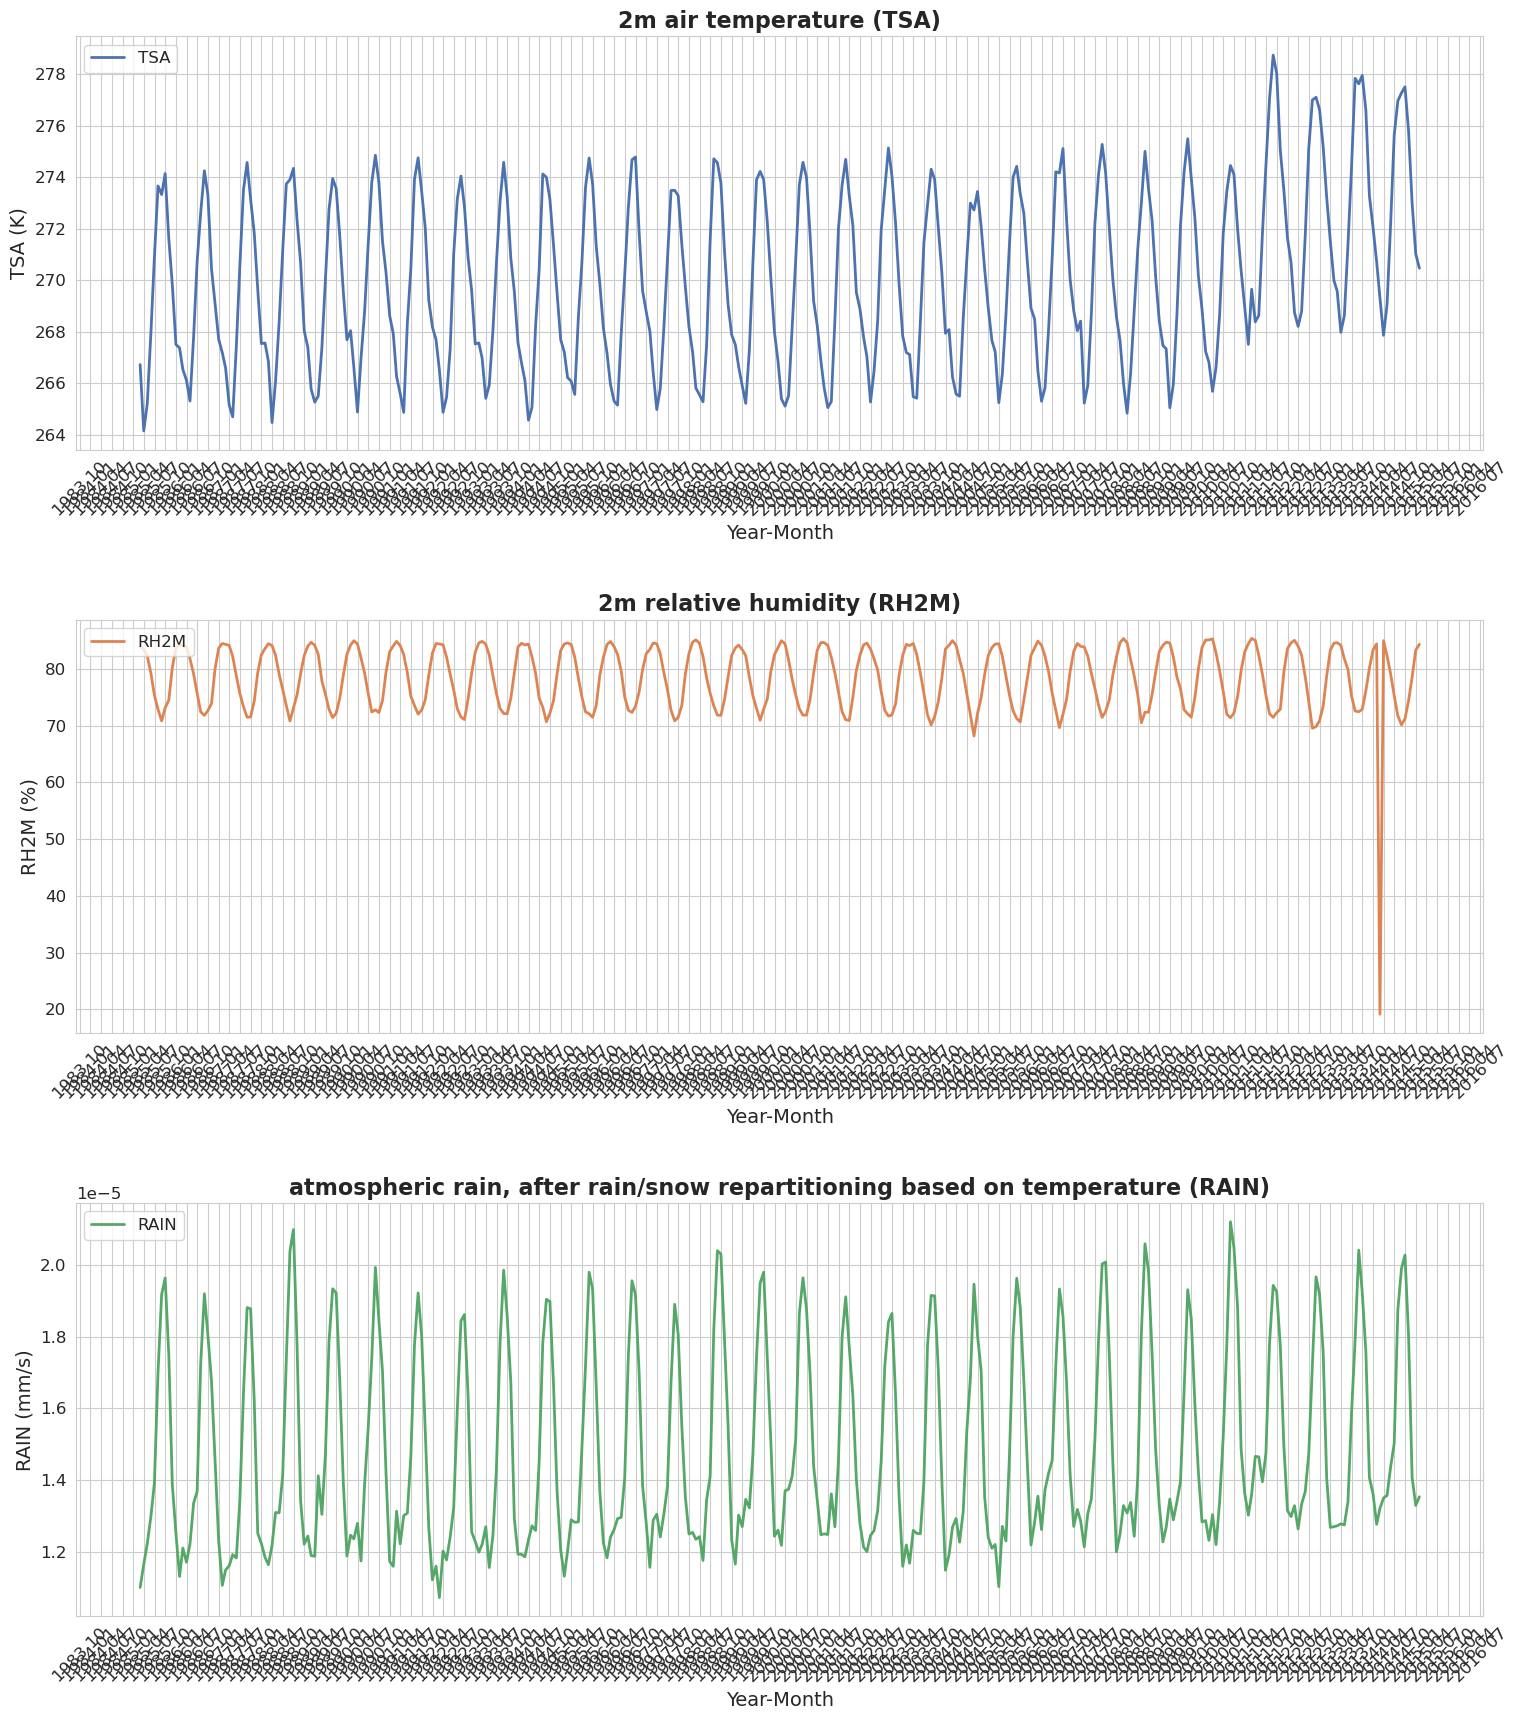

In [44]:
# Styling
sns.set_style("whitegrid")  # Use seaborn's whitegrid style
plt.rcParams['font.size'] = 12  # Increase default font size

# Create subplots for each variable
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 18))

colors = sns.color_palette("deep", 3)  # A palette of 3 distinct colors

for ax, var, color in zip(axes, variables, colors):
    ax.plot(monthly_avg['time'], monthly_avg[var], label=var, color=color, linewidth=2)

    ax.set_xlabel('Year-Month', fontsize=14)
    ax.set_ylabel(f'{var} ({ds[var].attrs.get("units", "unknown units")})', fontsize=14)  # Retrieving units from dataset attributes

    # Fetching long_name from attributes and forming the title
    long_name = ds[var].attrs.get('long_name', var)  # Using var as default if long_name is absent
    ax.set_title(f'{long_name} ({var})', fontsize=16, fontweight='bold')

    ax.legend(loc='upper left')

    # Format x-axis to show dates in "YYYY MM" format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Set tick every 3 months
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout(pad=3)  # Adjust padding
plt.show()


# Summer and Winter Results
    # https://docs.xarray.dev/en/stable/examples/monthly-means.html


## Testing code to split northern and southern hemisphere

In [45]:
# Testing Code to Separate Northern and Southern Hemispheres
northern = ds.sel(lat=slice(0, 90))  # Northern Hemisphere (0 to 90 degrees North)
southern = ds.sel(lat=slice(-90, 0))  # Southern Hemisphere (-90 to 0 degrees North)


In [46]:
(northern["QBOT"])

<xarray.DataArray 'QBOT' (time: 360, lat: 96, lon: 288)>
dask.array<getitem, shape=(360, 96, 288), dtype=float32, chunksize=(2, 96, 288), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1985-02-01 1985-03-01 ... 2015-01-01
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 0.4712 1.414 2.356 3.298 ... 87.17 88.12 89.06 90.0
Attributes:
    long_name:     atmospheric specific humidity (downscaled to columns in gl...
    units:         kg/kg
    cell_methods:  time: mean

In [47]:
(southern["QBOT"])

<xarray.DataArray 'QBOT' (time: 360, lat: 96, lon: 288)>
dask.array<getitem, shape=(360, 96, 288), dtype=float32, chunksize=(2, 96, 288), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1985-02-01 1985-03-01 ... 2015-01-01
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... -2.356 -1.414 -0.4712
Attributes:
    long_name:     atmospheric specific humidity (downscaled to columns in gl...
    units:         kg/kg
    cell_methods:  time: mean

In [48]:
ds['QBOT'].time

<xarray.DataArray 'time' (time: 360)>
array(['1985-02-01T00:00:00.000000000', '1985-03-01T00:00:00.000000000',
       '1985-04-01T00:00:00.000000000', ..., '2014-11-01T00:00:00.000000000',
       '2014-12-01T00:00:00.000000000', '2015-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1985-02-01 1985-03-01 ... 2015-01-01

## Testing code to extract summer months

In [49]:
northern_summer = northern.sel(time=northern['time.season'] == 'JJA')
southern_summer = southern.sel(time=southern['time.season'] == 'DJF')

In [50]:
southern_summer

<xarray.Dataset>
Dimensions:        (levgrnd: 25, levlak: 10, levdcmp: 1, time: 90, lon: 288,
                    lat: 96, hist_interval: 2)
Coordinates:
  * levgrnd        (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levlak         (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp        (levdcmp) float32 1.0
  * time           (time) datetime64[ns] 1985-02-01 1985-12-01 ... 2015-01-01
  * lon            (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat            (lat) float32 -90.0 -89.06 -88.12 ... -2.356 -1.414 -0.4712
Dimensions without coordinates: hist_interval
Data variables: (12/76)
    mcdate         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    mcsec          (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    mdcur          (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    mscur          (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    nstep          (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    time_bounds    (time, hist_interval) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...             ...
    VAPOR_PRES_U   (time, lat, lon) float32 dask.array<chunksize=(1, 96, 288), meta=np.ndarray>
    WASTEHEAT      (time, lat, lon) float32 dask.array<chunksize=(1, 96, 288), meta=np.ndarray>
    WBA            (time, lat, lon) float32 dask.array<chunksize=(1, 96, 288), meta=np.ndarray>
    WBA_R          (time, lat, lon) float32 dask.array<chunksize=(1, 96, 288), meta=np.ndarray>
    WBA_U          (time, lat, lon) float32 dask.array<chunksize=(1, 96, 288), meta=np.ndarray>
    WIND           (time, lat, lon) float32 dask.array<chunksize=(1, 96, 288), meta=np.ndarray>
Attributes: (12/38)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 02/13/24 20:20:28
    source:                                    Community Land Model CLM4.0
    hostname:                                  JohnnyThinkStation
    ...                                        ...
    ctype_urban_shadewall:                     73
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1

In [51]:
northern["time.season"]

<xarray.DataArray 'season' (time: 360)>
array(['DJF', 'MAM', 'MAM', 'MAM', 'JJA', 'JJA', 'JJA', 'SON', 'SON',
       'SON', 'DJF', 'DJF', 'DJF', 'MAM', 'MAM', 'MAM', 'JJA', 'JJA',
       'JJA', 'SON', 'SON', 'SON', 'DJF', 'DJF', 'DJF', 'MAM', 'MAM',
       'MAM', 'JJA', 'JJA', 'JJA', 'SON', 'SON', 'SON', 'DJF', 'DJF',
       'DJF', 'MAM', 'MAM', 'MAM', 'JJA', 'JJA', 'JJA', 'SON', 'SON',
       'SON', 'DJF', 'DJF', 'DJF', 'MAM', 'MAM', 'MAM', 'JJA', 'JJA',
       'JJA', 'SON', 'SON', 'SON', 'DJF', 'DJF', 'DJF', 'MAM', 'MAM',
       'MAM', 'JJA', 'JJA', 'JJA', 'SON', 'SON', 'SON', 'DJF', 'DJF',
       'DJF', 'MAM', 'MAM', 'MAM', 'JJA', 'JJA', 'JJA', 'SON', 'SON',
       'SON', 'DJF', 'DJF', 'DJF', 'MAM', 'MAM', 'MAM', 'JJA', 'JJA',
       'JJA', 'SON', 'SON', 'SON', 'DJF', 'DJF', 'DJF', 'MAM', 'MAM',
       'MAM', 'JJA', 'JJA', 'JJA', 'SON', 'SON', 'SON', 'DJF', 'DJF',
       'DJF', 'MAM', 'MAM', 'MAM', 'JJA', 'JJA', 'JJA', 'SON', 'SON',
       'SON', 'DJF', 'DJF', 'DJF', 'MAM', 'MAM', 'MAM', 'JJA', 'JJA',
       'JJA', 'SON', 'SON', 'SON', 'DJF', 'DJF', 'DJF', 'MAM', 'MAM',
       'MAM', 'JJA', 'JJA', 'JJA', 'SON', 'SON', 'SON', 'DJF', 'DJF',
       'DJF', 'MAM', 'MAM', 'MAM', 'JJA', 'JJA', 'JJA', 'SON', 'SON',
       'SON', 'DJF', 'DJF', 'DJF', 'MAM', 'MAM', 'MAM', 'JJA', 'JJA',
       'JJA', 'SON', 'SON', 'SON', 'DJF', 'DJF', 'DJF', 'MAM', 'MAM',
       'MAM', 'JJA', 'JJA', 'JJA', 'SON', 'SON', 'SON', 'DJF', 'DJF',
...
       'SON', 'DJF', 'DJF', 'DJF', 'MAM', 'MAM', 'MAM', 'JJA', 'JJA',
       'JJA', 'SON', 'SON', 'SON', 'DJF', 'DJF', 'DJF', 'MAM', 'MAM',
       'MAM', 'JJA', 'JJA', 'JJA', 'SON', 'SON', 'SON', 'DJF', 'DJF',
       'DJF', 'MAM', 'MAM', 'MAM', 'JJA', 'JJA', 'JJA', 'SON', 'SON',
       'SON', 'DJF', 'DJF', 'DJF', 'MAM', 'MAM', 'MAM', 'JJA', 'JJA',
       'JJA', 'SON', 'SON', 'SON', 'DJF', 'DJF', 'DJF', 'MAM', 'MAM',
       'MAM', 'JJA', 'JJA', 'JJA', 'SON', 'SON', 'SON', 'DJF', 'DJF',
       'DJF', 'MAM', 'MAM', 'MAM', 'JJA', 'JJA', 'JJA', 'SON', 'SON',
       'SON', 'DJF', 'DJF', 'DJF', 'MAM', 'MAM', 'MAM', 'JJA', 'JJA',
       'JJA', 'SON', 'SON', 'SON', 'DJF', 'DJF', 'DJF', 'MAM', 'MAM',
       'MAM', 'JJA', 'JJA', 'JJA', 'SON', 'SON', 'SON', 'DJF', 'DJF',
       'DJF', 'MAM', 'MAM', 'MAM', 'JJA', 'JJA', 'JJA', 'SON', 'SON',
       'SON', 'DJF', 'DJF', 'DJF', 'MAM', 'MAM', 'MAM', 'JJA', 'JJA',
       'JJA', 'SON', 'SON', 'SON', 'DJF', 'DJF', 'DJF', 'MAM', 'MAM',
       'MAM', 'JJA', 'JJA', 'JJA', 'SON', 'SON', 'SON', 'DJF', 'DJF',
       'DJF', 'MAM', 'MAM', 'MAM', 'JJA', 'JJA', 'JJA', 'SON', 'SON',
       'SON', 'DJF', 'DJF', 'DJF', 'MAM', 'MAM', 'MAM', 'JJA', 'JJA',
       'JJA', 'SON', 'SON', 'SON', 'DJF', 'DJF', 'DJF', 'MAM', 'MAM',
       'MAM', 'JJA', 'JJA', 'JJA', 'SON', 'SON', 'SON', 'DJF', 'DJF'],
      dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 1985-02-01 1985-03-01 ... 2015-01-01

## Real code start creating summer and winter datasets

In [63]:
# Filter dataset by the year 2000
ds_2000 = ds.sel(time=slice('1985', '1994'))
ds_2000

<xarray.Dataset>
Dimensions:        (levgrnd: 25, levlak: 10, levdcmp: 1, time: 119, lon: 288,
                    lat: 192, hist_interval: 2)
Coordinates:
  * levgrnd        (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levlak         (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp        (levdcmp) float32 1.0
  * time           (time) datetime64[ns] 1985-02-01 1985-03-01 ... 1994-12-01
  * lon            (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat            (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
Dimensions without coordinates: hist_interval
Data variables: (12/76)
    mcdate         (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    mcsec          (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    mdcur          (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    mscur          (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    nstep          (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    time_bounds    (time, hist_interval) object dask.array<chunksize=(2, 2), meta=np.ndarray>
    ...             ...
    VAPOR_PRES_U   (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WASTEHEAT      (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WBA            (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WBA_R          (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WBA_U          (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WIND           (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
Attributes: (12/38)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 02/13/24 20:20:28
    source:                                    Community Land Model CLM4.0
    hostname:                                  JohnnyThinkStation
    ...                                        ...
    ctype_urban_shadewall:                     73
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1

In [64]:
def set_unwanted_to_nan(ds):
    # Condition for JJA in the Northern Hemisphere
    condition_jja_nh = (ds['time.season'] == 'JJA') & (ds['lat'] >= 0)

    # Condition for DJF in the Southern Hemisphere
    condition_djf_sh = (ds['time.season'] == 'DJF') & (ds['lat'] < 0)

    # # Set grid cells to NaN where TSA_U is null
    # condition_tsa_u_not_null = ds['TSA_U'].notnull()

    # Combine conditions for the desired data, set others to NaN
    condition = (condition_jja_nh | condition_djf_sh) #& condition_tsa_u_not_null

    # Apply condition, keeping structure intact
    ds_filtered = ds.where(condition)

    return ds_filtered

In [65]:
ds_summer = set_unwanted_to_nan(ds_2000)
ds_summer

<xarray.Dataset>
Dimensions:        (time: 119, lat: 192, hist_interval: 2, lon: 288,
                    levgrnd: 25, levlak: 10, levdcmp: 1)
Coordinates:
  * levgrnd        (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levlak         (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp        (levdcmp) float32 1.0
  * time           (time) datetime64[ns] 1985-02-01 1985-03-01 ... 1994-12-01
  * lon            (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat            (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
Dimensions without coordinates: hist_interval
Data variables: (12/76)
    mcdate         (time, lat) float64 dask.array<chunksize=(2, 192), meta=np.ndarray>
    mcsec          (time, lat) float64 dask.array<chunksize=(2, 192), meta=np.ndarray>
    mdcur          (time, lat) float64 dask.array<chunksize=(2, 192), meta=np.ndarray>
    mscur          (time, lat) float64 dask.array<chunksize=(2, 192), meta=np.ndarray>
    nstep          (time, lat) float64 dask.array<chunksize=(2, 192), meta=np.ndarray>
    time_bounds    (time, hist_interval, lat) object dask.array<chunksize=(2, 2, 192), meta=np.ndarray>
    ...             ...
    VAPOR_PRES_U   (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WASTEHEAT      (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WBA            (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WBA_R          (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WBA_U          (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WIND           (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
Attributes: (12/38)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 02/13/24 20:20:28
    source:                                    Community Land Model CLM4.0
    hostname:                                  JohnnyThinkStation
    ...                                        ...
    ctype_urban_shadewall:                     73
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1

In [ ]:
#average of RAIN variable for summer
ds_rain_mean = ds_summer['RAIN'].mean(dim='time')
ds_rain_mean

In [89]:

#average for yearly total RAIN
yearly_avg_rain: xr.core.dataarray.DataArray = ds['RAIN'].sum(dim='time')/10.0
yearly_avg_rain = yearly_avg_rain.compute() 

In [90]:
yearly_avg_rain

<xarray.DataArray 'RAIN' (lat: 192, lon: 288)>
array([[6.7968770e-08, 6.7968770e-08, 6.7968770e-08, ..., 6.7968770e-08,
        6.7968770e-08, 6.7968770e-08],
       [4.8344901e-08, 4.2353811e-08, 4.1283410e-08, ..., 5.6989602e-08,
        5.7338514e-08, 5.7651469e-08],
       [2.8644360e-08, 1.9979563e-08, 2.0369761e-08, ..., 3.8627505e-08,
        3.8894825e-08, 3.9019422e-08],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0

In [91]:
df =yearly_avg_rain.to_dataframe(name='RAIN')
df

RAIN
lat   lon                 
-90.0 0.00    6.796877e-08
      1.25    6.796877e-08
      2.50    6.796877e-08
      3.75    6.796877e-08
      5.00    6.796877e-08
...                    ...
 90.0 353.75  0.000000e+00
      355.00  0.000000e+00
      356.25  0.000000e+00
      357.50  0.000000e+00
      358.75  0.000000e+00

[55296 rows x 1 columns]

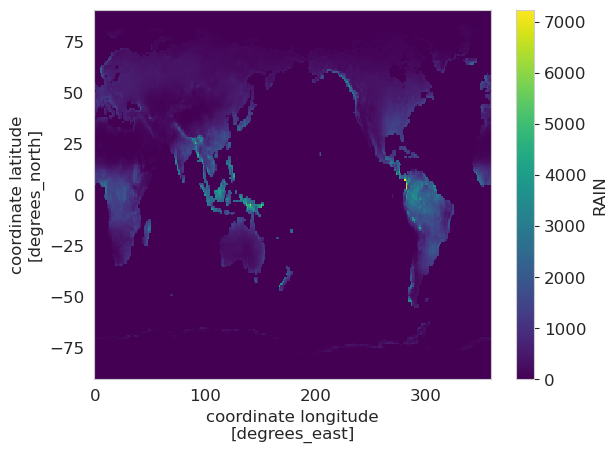

In [74]:
yearly_avg_rain.plot()

In [52]:


# Separate Northern and Southern Hemispheres
northern = ds_2000.sel(lat=slice(0, 90))  # Northern Hemisphere (0 to 90 degrees North)
southern = ds_2000.sel(lat=slice(-90, 0))  # Southern Hemisphere (-90 to 0 degrees North)

# Define seasons
seasons = {
    'summer': {'nh': 'JJA', 'sh': 'DJF'},
    'winter': {'nh': 'DJF', 'sh': 'JJA'}
}

seasonal_means = {}  # To store computed means for each season and variable

for season_name, season_months in seasons.items():
    northern_season = northern.sel(time=northern['time.season'] == season_months['nh'])
    southern_season = southern.sel(time=southern['time.season'] == season_months['sh'])

    northern_season_mean = northern_season.mean(dim='time').compute()
    southern_season_mean = southern_season.mean(dim='time').compute()

    combined_season_mean = xr.concat([southern_season_mean, northern_season_mean], dim='lat')
    seasonal_means[season_name] = combined_season_mean  # Store in the dictionary



## Get global min and max for each variable across both seasons so that we can plot side by side on the same scale

In [53]:
scale_limits = {}
for var in variables:
    combined_data = xr.concat([seasonal_means['summer'][var], seasonal_means['winter'][var]], dim='time')
    scale_limits[var] = {'vmin': combined_data.min(), 'vmax': combined_data.max()}

    # Convert Dask-backed values to scalars
    scale_limits[var]['vmin'] = float(scale_limits[var]['vmin'].compute())
    scale_limits[var]['vmax'] = float(scale_limits[var]['vmax'].compute())


## Plotting variables Summer and Winter side by side

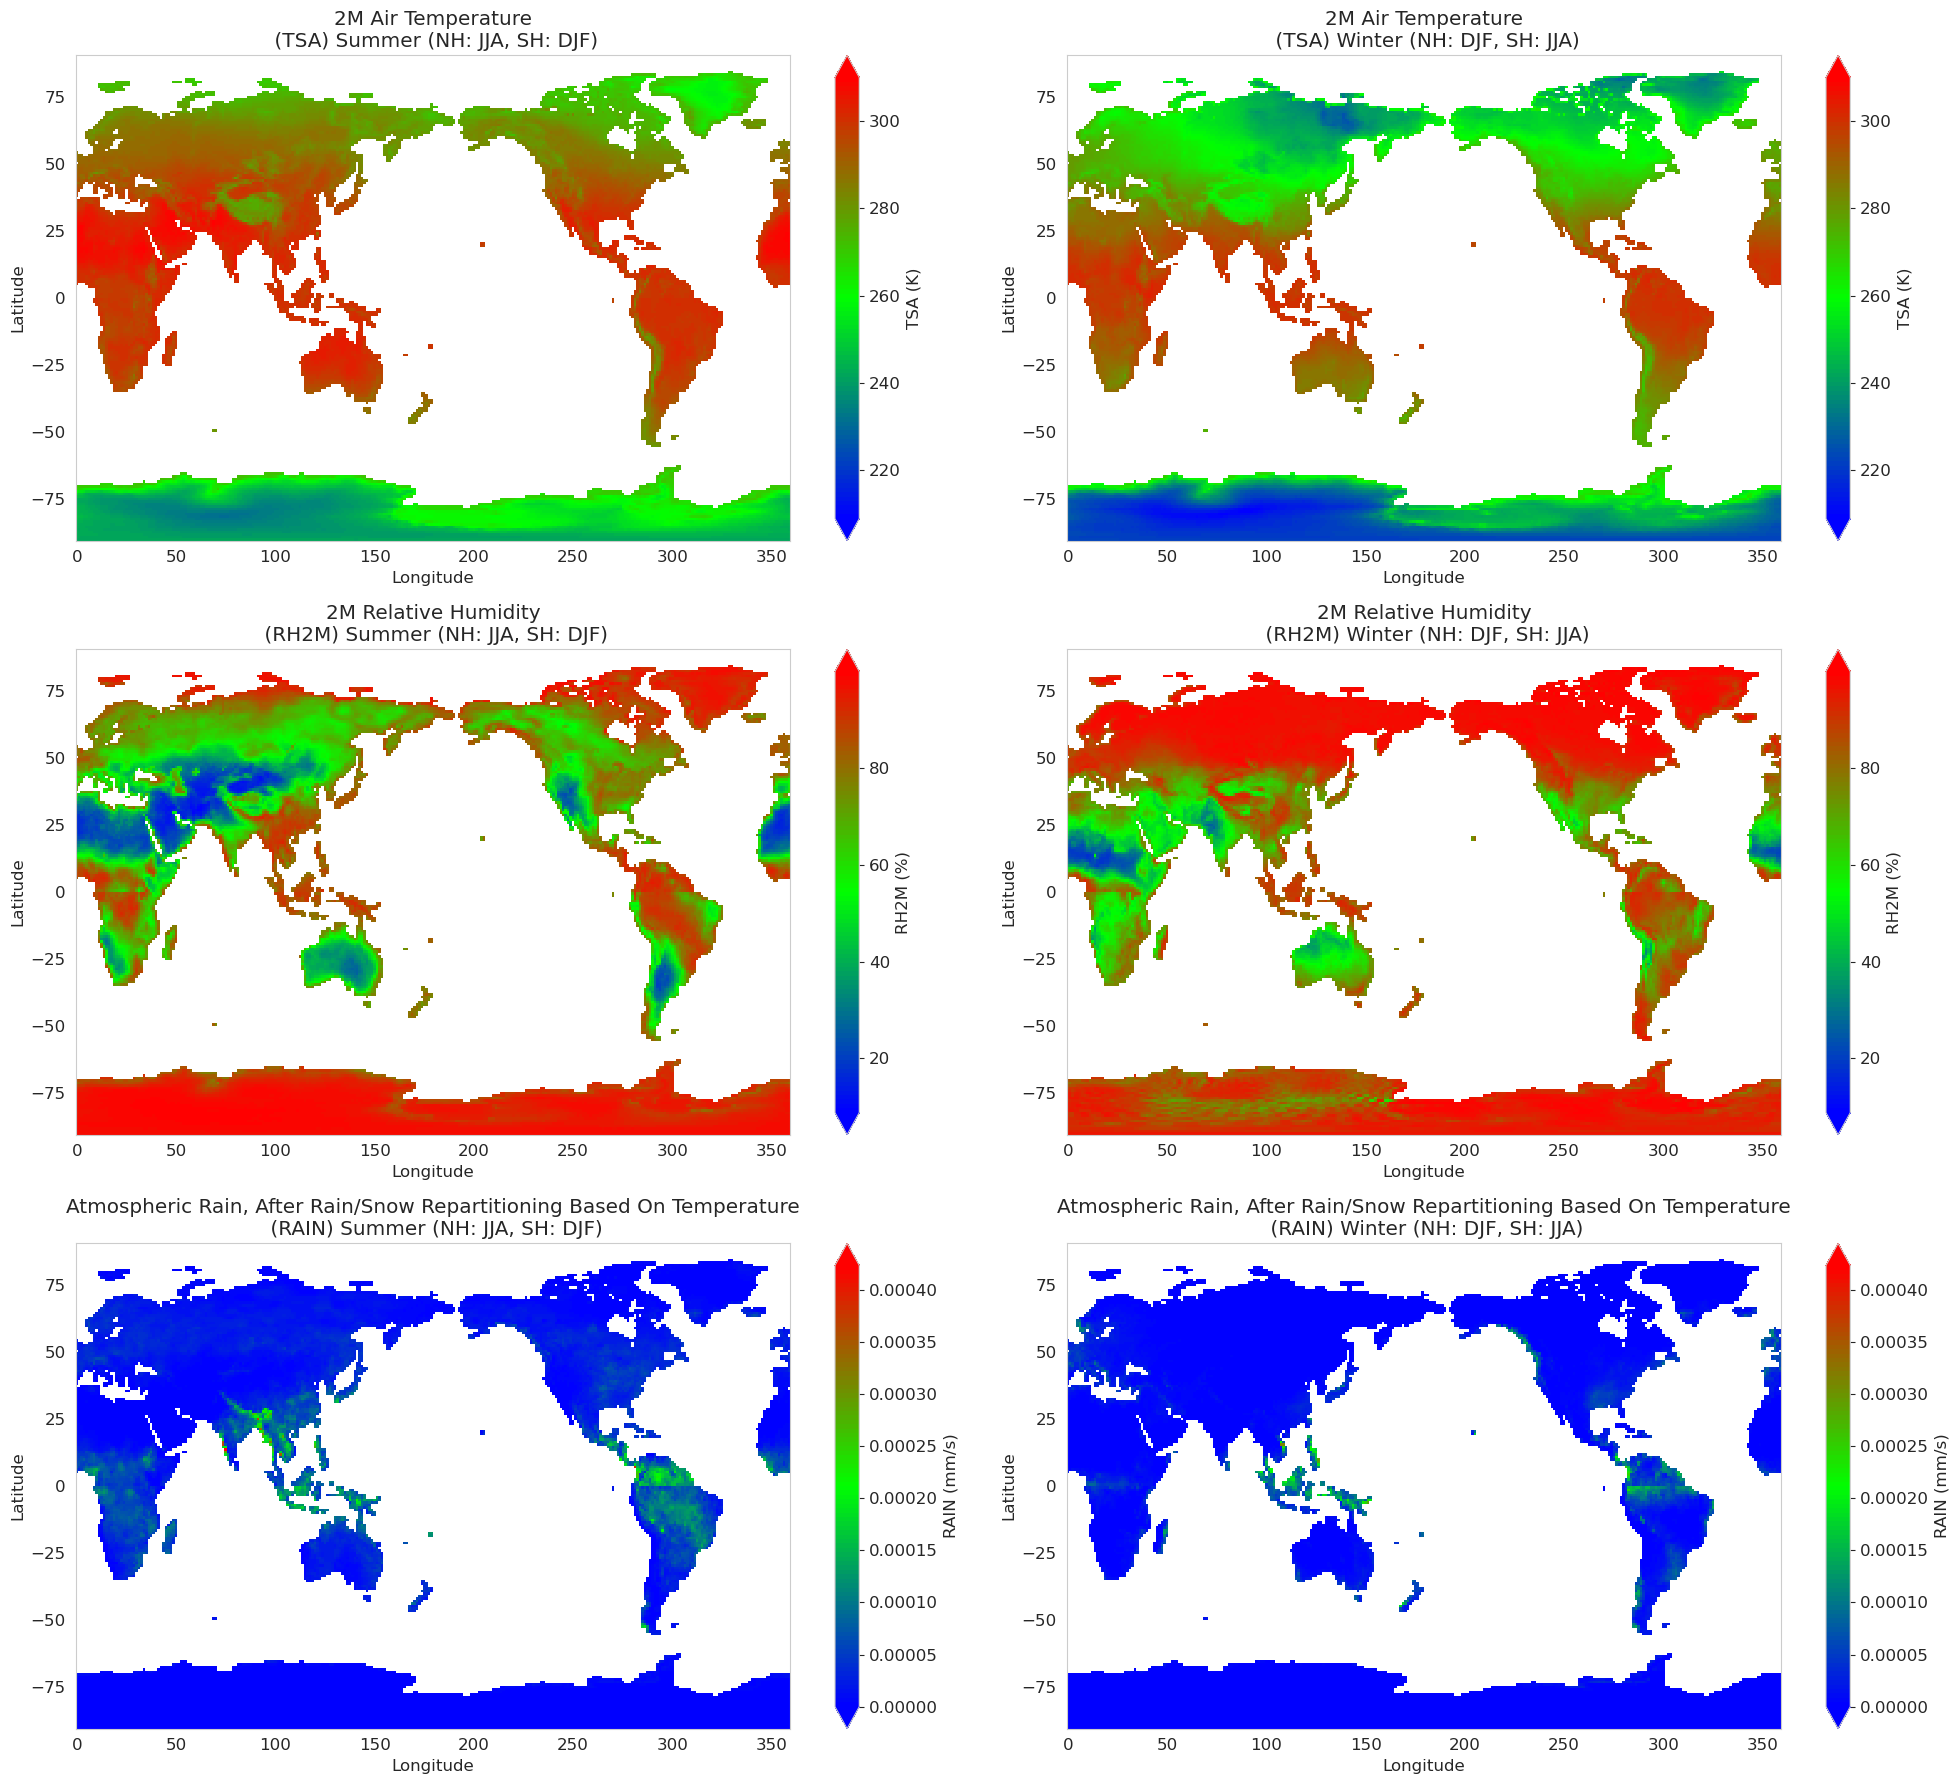

In [54]:
import matplotlib.colors as mcolors

# Custom colormap: Blue-Green-Red
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # B -> G -> R
n_bins = [3]  # Discretizes the interpolation into bins
cmap_name = 'custom_div_cmap'
cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

fig, axes = plt.subplots(nrows=len(variables), ncols=2, figsize=(20, 18))  # len(variables) rows, 2 seasons

for season_name, season_months in seasons.items():
    col = 0 if season_name == 'summer' else 1  # Summer in first column, Winter in second column

    for idx, var in enumerate(variables):
        ax = axes[idx, col]  # Get appropriate axis using the index

        data = seasonal_means[season_name][var]  # Fetch pre-computed data
        unit = ds[var].attrs.get('units', 'unknown unit')
        long_name = ds[var].attrs.get('long_name', var)  # Using var as default if long_name is absent

        p = data.plot(ax=ax, vmin=scale_limits[var]['vmin'], vmax=scale_limits[var]['vmax'], cmap=cm, add_colorbar=True, extend='both')
        p.colorbar.set_label(f"{var} ({unit})")

        # Other visual enhancements
        ax.set_title(f'{long_name.title()}\n ({var}) {season_name.capitalize()} (NH: {season_months["nh"]}, SH: {season_months["sh"]})')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')

plt.tight_layout()
plt.show()


